My first run through this experimentation will be following the model from the paper [Artist Identification with Convulutional Neural Networks](http://cs231n.stanford.edu/reports/2017/pdfs/406.pdf), and working with the [same dataset from Kaggle](https://www.kaggle.com/c/painter-by-numbers). I will initially only be working with a subset of the dataset, train_1.zip, partly due to my ISP's data caps and my current computer setup. In the following month I hope to be able to download more of the data set. I will be using PyTorch for my neural network(s).

In [1]:
%matplotlib inline

In [2]:
import csv
import os
from os.path import expanduser

#trim the irrelevant files; make a csv of our subset of the data
data_dir = expanduser("~") +"/Data/"
all_artist_data = data_dir + "all_artist_data.csv"
train1_csv = data_dir + "artist_train1.csv"
artist_train = data_dir + "artist_train1"

with open(train1_csv, "w") as to_write, open(all_artist_data) as to_read:
    files = set(os.listdir(artist_train))
    writer = csv.writer(to_write, delimiter=",",quotechar='\"')

    reader = csv.reader(to_read, quotechar='\"')
    header = next(reader)
    writer.writerow(header)
    for row in reader:
        if row[-1] in files:
            writer.writerow(row)

In [3]:
art_map = {}
label_to_artist = {}
label_counter = 0

with open(train1_csv, "r", encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, quotechar='\"')
    header = next(reader)
    for row in reader:
        label_to_artist[label_counter] = row[0]
        art_map[row[-1]] = label_counter
        label_counter += 1

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaslineCNN(nn.Module):
    
    def __init__(self):
        super(BaslineCNN, self).__init__()
        # 3 input channels, 32 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,32,3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32,32,3, stride=2, padding=1)
        self.fc1 = nn.Linear(6272,228)
        self.fc2 = nn.Linear(228,1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        print(x.size())
        x = x.view(-1, 6272)
        print(x.size())
        x = F.relu(self.fc1(x))
        print(x.size())
        x = F.relu(self.fc2(x))
        print(x.size())
        return x
        
net = BaslineCNN()
    
print(net)

BaslineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=228, bias=True)
  (fc2): Linear(in_features=228, out_features=1, bias=True)
)


Now we want to load in an transform our data into proper format. This involves implementing the Dataset asbtract class as well as the DataLoader class with versions specific to our data and our desired transformations. To follow along with the paper, we are going to randomly crop 224x244 images out of the training images. 

In [5]:
import pandas as pd
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from PIL import Image

train_loader_transform = transforms.Compose([transforms.RandomCrop(224),
                                             transforms.ToTensor()])

# custom loading solution found on StackOverflow:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader

class ArtistImageDataset(torch.utils.data.Dataset):
    def __init__(self,text_file,img_dir,transform=train_loader_transform):
        self.name_frame = pd.read_csv(text_file,sep=",",usecols=range(11,12))
        self.label_frame = pd.read_csv(text_file,sep=",",usecols=range(1))
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir, self.name_frame.iloc[index, 0])
        image = Image.open(img_name)
        image = self.transform(image)
        labels = self.label_frame.iloc[index, 0]
        sample = {'image': image, 'labels': labels}

        return sample
    
artistImageTrainSet = ArtistImageDataset(text_file=train1_csv, img_dir = artist_train)

artistTrainLoader = torch.utils.data.DataLoader(
    artistImageTrainSet,
    batch_size=16,
    shuffle=True,
    num_workers=2)

Maurice Prendergast, Isaac Levitan, Roy Lichtenstein, Theodor Philipsen, Jose Clemente Orozco, Ernst Ludwig Kirchner, Thomas Girtin, Remedios Varo, Giorgione, Theodor Severin Kittelsen, Pericles Pantazis , Claude Lorrain, Lucian Freud, Gerrit Dou, Alma Woodsey Thomas, William Blake


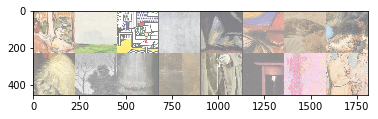

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# image-showing code taken from the PyTorch tutorial

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(artistTrainLoader)
sample = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(sample['image']))
# print labels
print(', '.join(sample['labels']))

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

In [8]:
  
for epoch in range(2):
    
    running_loss = 0
    
    for i, data in enumerate(artistTrainLoader):
        sample = data
        print(sample['labels'])
        optimizer.zero_grad()
        
        outputs = net(sample['image'])
        loss = criterion(outputs, sample['labels'])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('done')

torch.Size([16, 32, 56, 56])
torch.Size([16, 32, 14, 14])
torch.Size([16, 6272])
torch.Size([16, 228])
torch.Size([16, 1])


AttributeError: 'list' object has no attribute 'requires_grad'